# COMP 364 - Computer Tools for Life Sciences (Fall 2017) 
## Assignment #4 : Machine learning in cheminformatics
### <span style="color:red"> Due: Thursday December 1st, 2017 at 11:59:59 pm </span>

------

In this COMP 364 assignment you will implement a machine-learned model to predict the **median toxic dose (TD$_{50}$)** of specific molecules for mice. The TD$_{50}$ is the dose of a chemical required to cause an expected toxic effect in 50% of cases. For more information about the TD$_{50}$, please see the following links:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**TD$_{50}$ Wikipedia:** https://en.wikipedia.org/wiki/Median_toxic_dose

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**TD$_{50}$ Visual representation**: http://www.derangedphysiology.com/main/core-topics-intensive-care/critical-care-pharmacology/Chapter%202.1.7/median-doses-ld50-ed50-and-td50

To begin, download the following machine learning toxicology dataset:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Chemical dataset:** ftp://ftp.ics.uci.edu/pub/baldig/learning/benigni/ISSCAN_v1a_774_10Dec04.sdf

You will notice that the dataset is in an unusual file format, called a **'structure-data file' (SDF)**. An SDF file is a chemical table (describes molecules and chemical reactions) in a human-readable format. For more information, see:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**SDF Wikipedia:** https://en.wikipedia.org/wiki/Chemical_table_file#SDF

To parse this file format, we will need to update our Python 3 package manager, Anaconda, to include the RDKit module:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**conda install -c** https://conda.anaconda.org/rdkit **rdkit**

Helpful links/tutorials for the assignment overall:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**NumPy API:** https://docs.scipy.org/doc/numpy-1.13.0/reference/

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Matplotlib API:** https://matplotlib.org/2.0.2/api/index.html

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**RDKit API:** http://www.rdkit.org/docs/api/index.html

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**RDKit tutoral:** http://www.rdkit.org/docs/GettingStartedInPython.html

------
## Part 1 - feature array creation (30 marks)
------

Machine learning models learn from fixed-size feature array representations of data. In our case, we will use the RDKit Python module to parse the SDF file previously downloaded and then create an array of features for our future machine learning model to learn from.

Start by reviewing the RDKit tutorial (above) and learn how to read a set of molecules from an SDF file.

In [2]:
from rdkit import Chem

sdf_filepath = "./ISSCAN_v1a_774_10Dec04.sdf"
suppl = Chem.SDMolSupplier(sdf_filepath)

Now, using the RDKit API (link above), for each molecule read from the SDF file, determine:

* the chemical name (i.e. '1,2-Dichloropropane')
* the TD$_{50}$ for mouse in log$_{10}$ (**hint:** use the NumPy module for the log transformation)

**Ignore any molecule that does not have a measured mouse TD$_{50}$.**

Store TD$_{50}$ values in a multi-level Python dictionary, where:

* the first-level's key is the molecule's chemical name
* the second-level's key is `'target'`

For example:

``` Python
print(molecule_dict["1,2-Dichloropropane"])
```

Outputs: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`{'target': 2.4409090820652177}`

In [10]:
import numpy as np

molecule_dict = {}
for mol in suppl:
    #print(list(mol.GetPropNames()))
    # get molecule's name and mouse-oral LD50 (id and target, respectively)
    try: 
        name = mol.GetProp("ChemName").strip()
        mouse_td50 = mol.GetProp("TD50_Mouse")
    except KeyError: continue
    except AttributeError: continue
    # filter for examples with measured mouse LD50
    if mouse_td50.isdigit():
        molecule_dict[name]={"target":np.log10(float(mouse_td50))}
print(len(molecule_dict.keys()))

126
{'target': 2.4409090820652177}


Improve upon the code above and write an updated version below that adds a second key to the second-level of the Python dictionary, called `'feature_array'`.

`'feature_array'` will point to a tuple containing an ordered list of features used to describe the current molecule.

We will start by building a simple feature array based on the count of atoms in a molecule. The possible atom symbols for any molecule in the dataset are the following:

``` Python
atom_symbols = ["Br","C","Cl","F","H","I","N","O","P","S"]
```

Your job is to build a function called '`get_feature_array`' that takes in an RDKit molecule object and returns an ordered tuple containing the counts of each atom symbol and mass for the current molecule. **You will need to read the RDKit API to learn the correct functions/methods to call.**

``` Python
def get_feature_array(mol_obj):
    """provide a useful docstring"""
    feature_list = []
    # insert your code here
    
    return tuple(feature_list)
```

For '1,2-Dichloropropane', your function should return the following:

``` Python
(0, 3, 2, 0, 6, 0, 0, 0, 0, 0, 112.98700000000001)
```

Store the returned tuple from '`get_feature_array`' in your Python dictionary appropriately.

For example:

``` Python
molecule_dict["1,2-Dichloropropane"]["feature_array"] = get_feature_array(curr_mol)
```

**Note:** when calculating the mass of a molecule, you must include the weight of Hydrogen ('H') atoms as well. The RDKit module does not provide a constant for the mass of 'H' and you should consider it to be the following:

``` Python
H_mass = 1.008
```

Iterate over the molecules read from the SDF file again and call your newly implemented '`get_feature_array`' function. Like before, store the returned tuple appropriately in the Python dictionary that you previously created (you should be overwriting the older tuple).

In [3]:
# define the mass of a 'H' atom
H_mass = 1.008
# all possible atoms in the dataset
atom_symbols = ["Br","C","Cl","F","H","I","N","O","P","S"]

def get_atoms_count(atom_seq_obj,feature_list):
    """Returns Python dictionary containing the count of atoms in the provided RDKit atom sequence object"""
    atoms_dict = {}
    total_mass = 0.0
    for atom in atom_seq_obj:
        symbol = atom.GetSymbol()
        num_H = atom.GetTotalNumHs()
        total_mass += atom.GetMass()+(num_H*H_mass)
        for key,val in zip([symbol,"H"],[1,num_H]):
            try: atoms_dict[key] += val
            except KeyError: atoms_dict[key] = val

    return atoms_dict,total_mass

def get_feature_array(mol_obj):
    """Returns feature array for provide RDKit molecule object"""
    feature_list = []
    # determine atoms and mass of molecule
    atoms_dict,total_mass = get_atoms_count(mol.GetAtoms(),feature_list)
    
    # add atoms to feature array
    for key in atom_symbols:
        try: feature_list.append(atoms_dict[key])
        except KeyError: feature_list.append(0)

    # add mass to feature array
    feature_list.append(total_mass)
    
    return tuple(feature_list)

for mol in suppl:
    try: 
        name = mol.GetProp("ChemName").strip()
        mouse_td50 = mol.GetProp("TD50_Mouse")
    except KeyError: continue
    except AttributeError: continue
    # filter for examples with measured mouse LD50
    if mouse_td50.isdigit():
        molecule_dict[name]["feature_array"] = get_feature_array(mol)   

Let's improve upon our basic feature array. 

Write an updated '`get_feature_array`' function below that returns an ordered tuple consisting of the following:

1. positions 1-10 are the counts of atom symbols in the molecule
2. position 11 is the mass of the molecule
3. position 12 is the number of rings in the molecule
4. positions 13-22 are the counts of atom symbols found within rings (i.e., aromatic atoms) of the molecule
5. position 23 is the total mass of aromatic atoms in the molecule

If you are unfamiliar with molecular aromaticity, please review the following link:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Aromaticity Wikiepedia:** https://en.wikipedia.org/wiki/Aromaticity

For example, '`1-Amino-2-Methylanthraquinone`'s feature array would be:

``` Python
(0, 15, 0, 0, 11, 0, 1, 2, 0, 0, 237.25799999999995, 3, 0, 12, 0, 0, 6, 0, 0, 0, 0, 0, 150.17999999999998)
```

In [4]:
def get_feature_array(mol_obj):
    """Returns feature array for provide RDKit molecule object"""
    feature_list = []
    # determine atoms and mass of molecule
    atoms_dict,total_mass = get_atoms_count(mol.GetAtoms(),feature_list)
    
    # add atoms to feature array
    for key in atom_symbols:
        try: feature_list.append(atoms_dict[key])
        except KeyError: feature_list.append(0)

    # add mass to feature array
    feature_list.append(total_mass)
    
    # determine the number of bonds
    #try: feature_list.append(mol_obj.GetNumBonds()+atoms_dict["H"])
    #except KeyError: feature_list.append(mol_obj.GetNumBonds())
        
    # determine the number of rings
    feature_list.append(mol_obj.GetRingInfo().NumRings())
    
    # determine number of aromatic atoms (i.e., atoms that make up rings) and total mass
    aromatic_atoms_dict,aromatic_total_mass = get_atoms_count(mol_obj.GetAromaticAtoms(),feature_list)
    for key in atom_symbols:
        try: feature_list.append(aromatic_atoms_dict[key])
        except KeyError: feature_list.append(0)
    feature_list.append(aromatic_total_mass)
    
    return tuple(feature_list)

for mol in suppl:
    try: 
        name = mol.GetProp("ChemName").strip()
        mouse_td50 = mol.GetProp("TD50_Mouse")
    except KeyError: continue
    except AttributeError: continue
    # filter for examples with measured mouse LD50
    if mouse_td50.isdigit():
        molecule_dict[name]["feature_array"] = get_feature_array(mol) 

------
## Part 2 - Matplotlib scatter plot (15 marks)
------

Now, let's build a useful visual for us to tell how well our machine learning models (that we will implement) are performing.

Create a function called '`create_scatterplot`' that requires the following arguments:

1. a list containing the x-values to be plotted
2. a list containing the y-values to be plotted
3. a string representing the plot's title
4. a string representing the plot's x-axis label
5. a string representing the plot's y-axis label

And one optional key-word Boolean argument, called '`log_scale`', whose default value is `False`. If the function is called and `log_scale` is set to `True`, then the x- and y-axes should be log scaled.

Your function's signature should be similar to the following:

``` Python
def create_scatterplot(x_vals, y_vals, title, x_label, y_label, log_scale=False):
    """provide a useful docstring"""
    # insert your code here
```

**Remember to close your plot once you have finished displaying it.**

Your `create_scatterplot()` function should also:

* calculate a _Spearman correlation_ for the provided x- & y-values and display it within the plot (**hint:** see the SciPy API)
* include a dashed-line to represent the plot's diagonal

The plot's diagonal should be based on the minimum and maximum data values plotted. For example, if the range of x-values is 10 to 20 and the range of y-values is 100 to 110, your diagonal should start at (10, 10) and end at (110,110).

For more information about correlations, please see the following links:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Correlation coefficients Wikipedia:** https://en.wikipedia.org/wiki/Correlation_coefficient

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Spearman correlation Wikipedia:** https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

An example of the expected plot to be produced is shown below by calling `create_scatterplot()` using the _total count of atoms_ as the x-values and _molecular weight_ as the y-values.

``` Python
# iterate over dictionary keys extracting the total number of atoms (x) and mass (y) for each molecule
x_vals,y_vals = [],[]
for key in molecule_dict.keys():
    x_vals.append(sum(molecule_dict[key]["feature_array"][:len(atom_symbols)]))
    y_vals.append(molecule_dict[key]["feature_array"][10])

create_scatterplot(x_vals,y_vals,"Molecular weight vs. number of atoms","Number of atoms in molecule","Molecular weight (g/mol)",True)
```
![example_scatterplot](http://cs.mcgill.ca/~cgonza11/COMP_364/Assignments/HW2_images/example_scatterplot.png)

Helpful links:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Matplotlib API:** https://matplotlib.org/2.0.2/api/index.html

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**SciPy API:** https://docs.scipy.org/doc/scipy/reference/


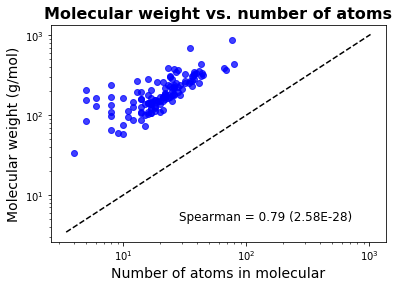

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

def create_scatterplot(x_vals,y_vals,title,x_label,y_label,log_scale=False):
    """Produces an inline Matplotlib scatter plot"""
    plt.title(title,fontweight="bold",size=16)
    plt.plot(x_vals,y_vals,"bo",alpha=0.75)
    rho,p_val = spearmanr(x_vals,y_vals)
    plt.text(0.9,0.1,"Spearman = {0:.2f} ({1:.2E})".format(rho,p_val),size=12,
             transform=plt.gca().transAxes,horizontalalignment="right")
    plt.xlabel(x_label,size=14)
    plt.ylabel(y_label,size=14)
    if(log_scale):
        plt.xscale("log",nonposx="clip")
        plt.yscale("log",nonposy="clip")
    # draw diagonal
    min_x,max_x = plt.xlim()
    min_y,max_y = plt.ylim()
    min_val = min(min_x,min_x)
    max_val = max(max_x,max_y)
    plt.plot([min_val,max_val],[min_val,max_val],"k--",lw=1.5)
    plt.show()

# iterate over dictionary keys and extract total number of atoms (x) and molecular weight (y)
x_vals,y_vals = [],[]
for key in molecule_dict.keys():
    x_vals.append(sum(molecule_dict[key]["feature_array"][:len(atom_symbols)]))
    y_vals.append(molecule_dict[key]["feature_array"][10])

create_scatterplot(x_vals,y_vals,"Molecular weight vs. number of atoms","Number of atoms in molecule","Molecular weight (g/mol)",True)

------
## Part 3 - training a machine learning model (20 marks)
------

Using the Python's scikit-learn module, we will train a **decision tree** to learn the relationship between our feature array and target values (i.e., TD$_{50}$).

If you are unfamiliar with decision trees (or would like to understand them better), we highly recommend the following tutorial:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Decision tree tutorial:** http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

Before we start to train our decision tree model, we need to split our data into _training_ and _testing_ datasets. The training dataset will be used to teach the decision tree how each feature (or combination of features) relate to the TD$_{50}$. The testing set will be used to measure the predictive accuracy (i.e., how close our decision tree's prediction is to the true TD$_{50}$ value) of our learned decision tree model.

To simplify our code, we will use our Python dictionary's keys (i.e., chemical names) as data examples.

Create a Python `list` variable called '`data`' and store the sorted keys of the dictionary within it.

In [6]:
data = sorted(list(molecule_dict.keys()))

Review the scikit-learn API (below) and split the set of example chemical names (`data`) into training and testing datasets, where the training dataset contains 80% of examples (and testing represents the remaining 20% of examples).

Helpful links/tutorials:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**scikit-learn API:** http://scikit-learn.org/stable/modules/classes.html

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**scikit-learn tutorials:** http://scikit-learn.org/stable/

In [7]:
from sklearn.model_selection import train_test_split

# split example molecules into train and test data sets
train,test = train_test_split(data,test_size=0.2,random_state=None)

Now that we have split our example molecules into training (80%) and testing (20%), we will use the former dataset to train a decision tree regressor using the scikit-learn module.

To train your model, you will need to create lists of _input_ and _output_ for the model, where:

* each item in _input_ is a '`feature_array`' for each example from the training dataset
* each item in _output_ is the paired '`target`' (i.e., TD$_{50}$ in log$_{10}$) for each item found within _input_

You will then use these two lists to train a descision tree regressor implementation from scikit-learn.

Write the necessary Python code below to train a decision tree regressor to predict TD$_{50}$ values.

In [8]:
from sklearn.tree import DecisionTreeRegressor

train_X = [molecule_dict[val]["feature_array"] for val in train]
train_Y = [molecule_dict[val]["target"] for val in train]
regr = DecisionTreeRegressor()
regr.fit(train_X,train_Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Now that you have a learned decision tree model, we can use it to predict on unforeseen examples (i.e., the testing dataset). 

Write the necessary Python code to create a set of predictions from your learned model using the testing dataset below.

In [9]:
test_X = [molecule_dict[val]["feature_array"] for val in test]
test_Y = [molecule_dict[val]["target"] for val in test]
pred = regr.predict(test_X)

Using the scatter plot function that you have implemented above, plot a scatter plot representing the comparison of decision tree predicted and true TD$_{50}$ values for the _test_ dataset.

Calculate the **mean squared error (MSE)** of predicted and true TD$_{50}$ values from the _test_ dataset (see the scikit-learn module API) and include it in your plot's title. Your plot should look similar to the following:

![decision_tree_pred](http://cs.mcgill.ca/~cgonza11/COMP_364/Assignments/HW2_images/decision_tree_pred.png)

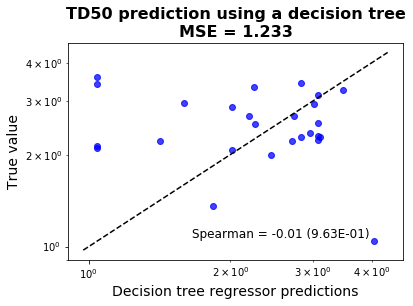

In [10]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(test_Y,pred)
create_scatterplot(pred,test_Y,"TD50 prediction using a decision tree\nMSE = "+str(round(MSE,3)),
                   "Decision tree regressor predictions","True value",True)

**How well do you think your model is performing?**

_In 3-4 sentences at most, explain the performance of your regressor based on your scatter plot/Spearman correlation above that compares predicted and true TD$_{50}$ values. (i.e., how accurate is your predictor? does there appear to be a relationship between the current model features and target values?)_

The predictor has a reasonable MSE value, but there does not appear to be a linear relationship between predicted and true TD$_{50}$ values (i.e., low TD$_{50}$ values are not necessarily predicted to be low and vice-versa). The current set of model features may not be the best for predicting target values.

------
## Part 4 - feature importance (15 marks)
------

Training machine learning models to learn the relationship between input and output can be quite useful.

In biology (or similar fields), we are usually more interested in the significance of features used in the model (i.e., how important is a given feature to the predictive capabilities of a model?). In the case of this assignment, one could ask "How important is the count of 'H' atoms to the model's ability to predict TD$_{50}$?"

Review the scikit-learn API/tutorial and learn how to extract 'feature importance' from your learned model.

Write your own Python code below to sort model features by importance in a descending order and remove any features with an importance value of zero.

In [11]:
feature_labels = ["num_Br","num_C","num_Cl","num_F","num_H","num_I","num_N","num_O","num_P","num_S"
                  ,"total_mass","num_rings","num_aro_Br","num_aro_C","num_aro_Cl","num_aro_F"
                  ,"num_aro_H","num_aro_I","num_aro_N","num_aro_O","num_aro_P","num_aro_S","total_mass_aro"]
# sort feature labels by importance in model
labels,bar_heights = zip(*sorted(zip(feature_labels,regr.feature_importances_),key=lambda x:float(x[1]),reverse=True))
# filter features with zero importance
labels,bar_heights = zip(*[(label,bar_height) for label,bar_height in zip(labels,bar_heights) if bar_height>0.0])

Create a function called '`create_barplot`' that displays feature importance of your regressor as a Matplotlib barplot, where the:

* y-axis is the feature importance measure
* x-axis is the features used in the model

Your function's signature should be similar to the following:

``` Python
def create_barplot(x_labels,bar_heights):
    """provide a useful docstring"""
```

where `x_labels` is a list of strings to be used as the x-tick labels of the plot and `bar_heights` is a list containing the importance of each feature.

Your plot should look similar to the following:

![feature_importance](http://cs.mcgill.ca/~cgonza11/COMP_364/Assignments/HW2_images/feature_importance)

Call your function and pass in the sorted features you created above.

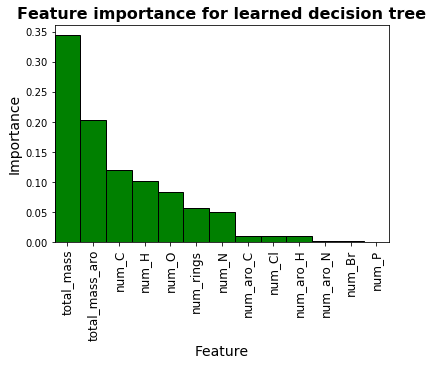

In [12]:
def create_barplot(x_labels,bar_heights):
    """Produces an inline Matplotlib bar plot"""
    plt.title("Feature importance for learned decision tree",fontweight="bold",size=16)
    N = range(len(x_labels))
    plt.bar(N,bar_heights,1.0,color="g",edgecolor="k")
    plt.xlim([-0.5,len(x_labels)-0.5])
    xticks = [i for i in N]
    plt.xticks(xticks,labels,rotation="vertical",size=12)
    plt.xlabel("Feature",size=14)
    plt.ylabel("Importance",size=14)
    plt.show()
    
create_barplot(labels,bar_heights)

------
## Part 5 - open problem (20 marks)
------

In most machine learning problems, you do not know what the best model or feature array is. Researchers spend many months (to years) refining models to provide more accurate predictions.

In parts 1-3, you followed the provided instructions to obtain a model for predicting TD$_{50}$ values in mice. 

For the remainder of this assignment, you will perform your own research and implement potential improvements to our predictive model of TD$_{50}$.

Start by reviewing the RDKit API/tutorial and the following link:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Toxicity Wikipedia:** https://en.wikipedia.org/wiki/Toxicity

### a) create and implement a new feature
------

Suggest a potential new feature that could lead to an improvement in machine learned model's predictions. Make sure you provide a rational argument and biological support (biological reasoning for it's importance) for your new feature. (_3-4 sentences at most_)

I propose we incorporate a feature that represents the '`num_of_bonds`' into the model to improve predictive accuracy. The number of bonds present in a molecule could inform the machine about the structure of a molecule. Molecule structure is important for binding to other substances within an organism that could lead to toxic effects. 

Write a new '`get_feature_array()`' function below.

This new function definition will include the addition of your new feature to the end of the '`feature_array`' for each chemical in the Python dictionary.

In [13]:
def get_feature_array(mol_obj):
    """Returns feature array for provide RDKit molecule object"""
    feature_list = []
    # determine atoms and mass of molecule
    atoms_dict,total_mass = get_atoms_count(mol.GetAtoms(),feature_list)
    
    # add atoms to feature array
    for key in atom_symbols:
        try: feature_list.append(atoms_dict[key])
        except KeyError: feature_list.append(0)

    # add mass to feature array
    feature_list.append(total_mass)
        
    # determine the number of rings
    feature_list.append(mol_obj.GetRingInfo().NumRings())
    
    # determine number of aromatic atoms (i.e., atoms that make up rings) and total mass
    aromatic_atoms_dict,aromatic_total_mass = get_atoms_count(mol_obj.GetAromaticAtoms(),feature_list)
    for key in atom_symbols:
        try: feature_list.append(aromatic_atoms_dict[key])
        except KeyError: feature_list.append(0)
    feature_list.append(aromatic_total_mass)
    
    # determine the number of bonds
    try: feature_list.append(mol_obj.GetNumBonds()+atoms_dict["H"])
    except KeyError: feature_list.append(mol_obj.GetNumBonds())
    
    return tuple(feature_list)

for mol in suppl:
    try: 
        name = mol.GetProp("ChemName").strip()
        mouse_td50 = mol.GetProp("TD50_Mouse")
    except KeyError: continue
    except AttributeError: continue
    # filter for examples with measured mouse LD50
    if mouse_td50.isdigit():
        molecule_dict[name]["feature_array"] = get_feature_array(mol)   

Train a decision tree regressor on the new feature array and create a scatter plot that compares the model prediction's against the true values (**hint:** reuse your _train_ and _test_ datasets from before).

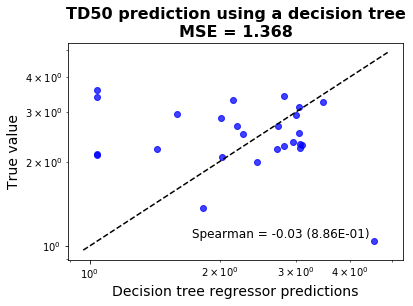

In [14]:
train_X = [molecule_dict[val]["feature_array"] for val in train]
train_Y = [molecule_dict[val]["target"] for val in train]
regr = DecisionTreeRegressor()
regr.fit(train_X,train_Y)
test_X = [molecule_dict[val]["feature_array"] for val in test]
test_Y = [molecule_dict[val]["target"] for val in test]
pred = regr.predict(test_X)
MSE = mean_squared_error(test_Y,pred)
create_scatterplot(pred,test_Y,"TD50 prediction using a decision tree\nMSE = "+str(round(MSE,3)),
                   "Decision tree regressor predictions","True value",True)

**Has your model's performance improved?** (_3-4 sentences at most_)

Model performance has actually worsened with the addition of the new feature.

Create a barplot (like before) of your new model's feature importance.

Remember to sort your features by importance in a descending order and remove any feature that has no importance attributed to it.

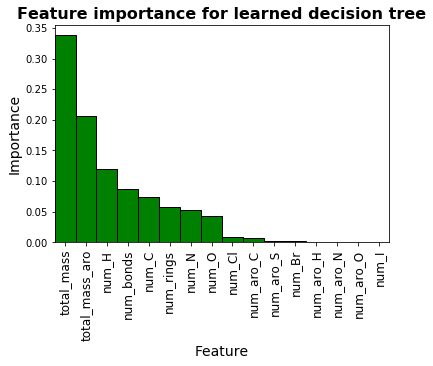

In [16]:
feature_labels = ["num_Br","num_C","num_Cl","num_F","num_H","num_I","num_N","num_O","num_P","num_S"
                  ,"total_mass","num_rings","num_aro_Br","num_aro_C","num_aro_Cl","num_aro_F"
                  ,"num_aro_H","num_aro_I","num_aro_N","num_aro_O","num_aro_P","num_aro_S","total_mass_aro","num_bonds"]
# sort feature labels by importance in model
labels,bar_heights = zip(*sorted(zip(feature_labels,regr.feature_importances_),key=lambda x:float(x[1]),reverse=True))
# filter features with zero importance
labels,bar_heights = zip(*[(label,bar_height) for label,bar_height in zip(labels,bar_heights) if bar_height>0.0])
create_barplot(labels,bar_heights)

**How has your new feature performed? Was it considered to be significant by the machine learning algorithm?** (_3-4 sentences at most_)

The '`num_bonds`' feature does have importance attributed to it, but the model's performance has not improved.

### b) implement a different model
------

Review the scikit-learn API and suggest a new machine learning model architecture (different than the decision tree) to implement using Python scikit-learn module.

Provide a rational argument for why you expect this model to provide improved predictions for the TD$_{50}$ problem. (_3-4 sentences at most_)

Artificial neural networks (ANNs) are proven models in the machine learning community and have been shown to perform well on similar regression problems. In our case, we may not have enough examples for the network to learn the underlying relationship between features and median toxicity dose.

Implement your new machine learning model architecture using the feature array you just created (i.e., with the additional feature) and create a scatter plot comparing it's predictions to the true TD$_{50}$ values.

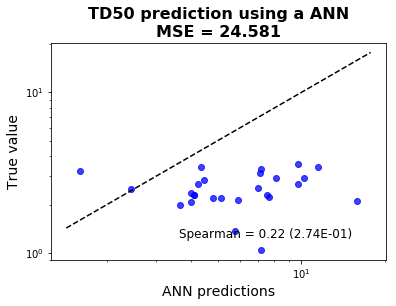

In [18]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(50,50,25,12),shuffle=True)
regr.fit(train_X,train_Y)
pred = regr.predict(test_X)
MSE = mean_squared_error(test_Y,pred)
create_scatterplot(pred,test_Y,"TD50 prediction using a ANN\nMSE = "+str(round(MSE,3)),
                   "ANN predictions","True value",True)

** Has your new machine learning model outperformed the original decision tree implementation from parts 3-4? Support your answer. ** (_3-4 sentences at most_) 

The ANN did not improve upon the decision tree (predictive accuracy is much worse).